# Decision tree to predict housing prices

In [79]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
from mlxtend.preprocessing import minmax_scaling
from math import log2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [132]:
df = pd.read_csv('/media/indranil/New Volume1/second sem/SMAI/Assignment 1/q3/dataset/train.csv')
df.drop(['Alley','PoolQC','Fence','MiscFeature'], axis =1, inplace = True)

In [135]:
nan_list = df.columns[df.isna().any()].tolist()
nan_list

[]

In [136]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace = True)
df['MasVnrType'].fillna(df['MasVnrType'].mode()[0], inplace = True)
df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace = True)
df['BsmtQual'].fillna(df['BsmtQual'].mode()[0], inplace = True)
df['BsmtCond'].fillna(df['BsmtCond'].mode()[0], inplace = True)
df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0], inplace = True)
df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0], inplace = True)
df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0], inplace = True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace = True)
df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0], inplace = True)
df['GarageType'].fillna(df['GarageType'].mode()[0], inplace = True)
df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean(), inplace = True)
df['GarageFinish'].fillna(df['GarageFinish'].mode()[0], inplace = True)
df['GarageQual'].fillna(df['GarageQual'].mode()[0], inplace = True)
df['GarageCond'].fillna(df['GarageCond'].mode()[0], inplace = True)

In [137]:
# columns_norm = ['MSSubClass','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
# df[columns_norm] = df[columns_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
# df

In [138]:
rng = RandomState()
train = df.sample(frac=0.8,random_state = rng)
#mean_price = train["SalePrice"].mean()
validation = df.loc[~df.index.isin(train.index)]
X_train, Y_train = train.iloc[:,1:], train.iloc[:,-1:]
X_validation, Y_validation = validation.iloc[:,1:-1], validation.iloc[:,-1:]
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_validation = np.array(X_validation)
Y_validation = np.array(Y_validation)
X_train.shape

(800, 76)

In [139]:
def set_int():
    return 9999,9999,None

In [140]:
def set_str():
    return 9999,"",None

In [141]:
def cal_rmse(groups):
    l_sum = 0
    r_sum = 0
    l_temp =0
    r_temp = 0 
#     print("len left ",len(groups[0]))
#     print("len right ",len(groups[1]))
    if(len(groups[0]) == 0 and len(groups[1]) == 0):
        return 0
    if(len(groups[0]) != 0):
        mean_price = 0
        left_sum = 0
        for row in groups[0]:
            left_sum = left_sum + row[-1]
        mean_price = left_sum/len(groups[0])
        for row in groups[0]:
            l_temp = l_temp + ((mean_price - row[-1])**2)
        l_sum = np.sqrt(l_temp/len(groups[0]))
    if (len(groups[1]) != 0): 
        mean_price = 0
        right_sum = 0
        for row in groups[1]:
            right_sum = right_sum + row[-1]
        mean_price = right_sum/len(groups[1])
        for row in groups[1]:
            r_temp = r_temp + ((mean_price - row[-1])**2)
        r_sum = np.sqrt(r_temp/len(groups[1]))
    #l_sum = np.sqrt(np.sum((mean_price - groups[0][:,-1:])**2)/len(groups[0]))
    #r_sum = np.sqrt(np.sum((mean_price - groups[1][:,-1:])**2)/len(groups[1]))
    total_len = len(groups[0])+len(groups[1])
    result = (((len(groups[0])*l_sum)/total_len) + (((len(groups[1])*r_sum)/total_len)))
    #print("result ",l_sum)
    return result

In [142]:
def terminate_node(group):
    sum_el = 0
    for row in group:
        sum_el = sum_el + row[-1]
   # print("sum/len ",sum_el/len(group))
    return sum_el/len(group)

In [143]:
def checker(value):
    if (type(value) is int or type(value) is float):
        #print("srtng")
        return True
    else:
        #print("int")
        return False

In [144]:
def test_split_num(index, value, train_data):
    left, right = list(), list()
    #print("index ",index)
    for row in train_data:
        #print("row index ",row[index])
        #print("value in num",value)
        if float(row[index]) <= float(value):
            left.append(row)
        else:
            right.append(row)
#     if(index == 0):
#         print("left ", len(left))
#         print("right ", len(right))
    return left, right

In [145]:
def test_split_str(index, value, train_data):
    left, right = list(), list()
    for row in train_data:
       # print("value in str ",value)
        if row[index] == value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [146]:
def del_groups(value):
    del value

In [147]:
def check_for_left_right(left,right):
    if not left or not right:
        return True
    else:
        return False

In [148]:
def check_for_max_depth(max_depth):
    if max_depth < 1:
        return True
    else:
        return False

In [149]:
def check_for_min_size(node,min_size):
    if (len(node) <= min_size):
        return True
    else:
        return False

In [150]:
def split_node(train_data,col_size):
    int_index, int_value, int_groups = set_int()
    str_index, str_value, str_groups = set_str()
    score = 999999999999999999
    for index in range(col_size):
        for row in train_data:
            #print("row index ",row[index])
            if (checker(row[index])):
              #  print("if index ",index)
                groups = test_split_num(index, row[index], train_data)
                rmse = cal_rmse(groups)
                if rmse < score:
#                     print("index ",index)
#                     print("rmse ",rmse)
#                     print("in loop int left groups 0", len(groups[0]))
#                     print("in loop int right groups 1", len(groups[1]))
                    int_index, int_value,score, int_groups = index, row[index], rmse, groups
                    str_groups = None
            else:
             #   print("else index ",index)
                groups = test_split_str(index, row[index], train_data)
                rmse = cal_rmse(groups)
                if rmse < score:
#                     print("index ",index)
#                     print("rmse ",rmse)
#                     print("in loop str left groups 0", len(groups[0]))
#                     print("in loop str right groups 1", len(groups[1]))
                    str_index, str_value, score, str_groups = index, row[index], rmse, groups
                    int_groups = None
    if(int_groups == None):
#         print("here str left groups 0", len(str_groups[0]))
#         print("here str right groups 1", len(str_groups[1]))
        return {'index':str_index, 'value':str_value, 'groups':str_groups}
    elif(str_groups == None):
#         print("here int left groups 0",len(int_groups[0]))
#         print("here int right groups 1",len(int_groups[1]))
        return {'index':int_index, 'value':int_value, 'groups':int_groups}
#     else:
#         print("none")
#         return

In [151]:
def split_tree(node, max_depth, min_size,col_size):
    #print("node groups ",node['groups'])
    left, right = node['groups']
    #print("left ",left)
    #print("right ",right)
    del_groups(node['groups'])
    if (check_for_left_right(left,right)) or (check_for_max_depth(max_depth)):
        if (check_for_left_right(left,right)):
            #print("bth null")
            node['left'] = node['right'] = terminate_node(left + right)
            return
        if (check_for_max_depth(max_depth)):
            #print("max depth")
            node['left'], node['right'] = terminate_node(left), terminate_node(right)
            return
    if (check_for_min_size(left,min_size)):
        #print("left terminate")
        node['left'] = terminate_node(left)
    else:
        #print("left len")
        node['left'] = split_node(left,col_size)
        split_tree(node['left'], max_depth-1, min_size,col_size)
    if (check_for_min_size(right,min_size)):
        #print("right term")
        node['right'] = terminate_node(right)
    else:
        #print("right len")
        node['right'] = split_node(right,col_size)
        split_tree(node['right'], max_depth-1, min_size,col_size)

In [152]:
def decision_tree(train_data,max_depth,min_element):
    col_size = train_data.shape[1]-1
    root = split_node(train_data,col_size)
    #print("max_depth ",root)
    split_tree(root,max_depth,min_element,col_size)
    return root

In [153]:
def make_prediction(root,row):
    #print("root index ",row[root['index']])
    #print("root value ",root['value'])
    if row[root['index']] <= root['value']:
        if isinstance(root['left'],dict):
            return make_prediction(root['left'], row)
        else:
     #       print("root left ",root['left'])
            return root['left']
    else:
        if isinstance(root['right'],dict):
            return make_prediction(root['right'], row)
        else:
      #      print("root right ",root['right'])
            return root['right']

In [154]:
def mean_square_error(y_real,y_prediction):
    summation = 0
    n = len(y_real)
    for i in range (0,n):
        difference = y_real[i] - y_prediction[i]
        squared_difference = difference**2
        summation = summation + squared_difference
    MSE = summation/n
    return MSE

In [155]:
def mean_absolute_error(y_real,y_prediction):
    summation = 0
    n = len(y_real)
    for i in range (0,n):
        difference = np.abs(y_real[i] - y_prediction[i])
        summation = summation + difference
        #print("Summation ",summation)
    MAE = summation/n
    return MAE

Decision Tree with keeping max depth of the tree 5 and minimum element in the leaf node upto 15 gives MSE of 1564865893.3726947 and MAE of 28322.58530841567 and R2 score of 0.7951481012789241

In [59]:
root_5_15 = decision_tree(X_train,5,15)
predictions = list()
for row in X_validation:
    res = make_prediction(root_5_15,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1564865893.3726947
MAE 28322.58530841567


0.7951481012789241

Decision Tree with keeping max depth of the tree 5 and minimum element in the leaf node upto 25 gives MSE of 1583456475.298631 and MAE of 28608.038025748156 and R2 score of 0.7927144639800436

In [45]:
root_5_25 = decision_tree(X_train,5,25)
predictions = list()
for row in X_validation:
    res = make_prediction(root_5_25,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1583456475.298631
MAE 28608.038025748156


0.7927144639800436

Decision Tree with keeping max depth of the tree 7 and minimum element in the leaf node upto 25 gives MSE of 1571453678.9234903 and MAE of 27947.050776099284 and R2 score of 0.7009349510646941

In [107]:
root_7_25 = decision_tree(X_train,7,25)
predictions = list()
for row in X_validation:
    res = make_prediction(root_7_25,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1571453678.9234903
MAE 27947.050776099284


0.7009349510646941

Decision Tree with keeping max depth of the tree 7 and minimum element in the leaf node upto 15 gives MSE of 1527207410.5406668 and MAE of 27244.20221521161 and R2 score of 0.8000778602721816

In [47]:
root_7_15 = decision_tree(X_train,7,15)
predictions = list()
for row in X_validation:
    res = make_prediction(root_7_15,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1527207410.5406668
MAE 27244.20221521161


0.8000778602721816

Decision Tree with keeping max depth of the tree 7 and minimum element in the leaf node upto 20 gives MSE of 1523807212.4273605 and MAE of 27176.342155847276 and R2 score of 0.8005229700048997

In [48]:
root_7_20 = decision_tree(X_train,7,20)
predictions = list()
for row in X_validation:
    res = make_prediction(root_7_20,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1523807212.4273605
MAE 27176.342155847276


0.8005229700048997

Decision Tree with keeping max depth of the tree 5 and minimum element in the leaf node upto 20 gives MSE of 1559390630.733721 and MAE of 28242.799579249 and R2 score of 0.7958648514824658

In [61]:
root_5_20 = decision_tree(X_train,5,20)
predictions = list()
for row in X_validation:
    res = make_prediction(root_5_20,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1559390630.733721
MAE 28242.799579249


0.7958648514824658

Decision Tree with keeping max depth of the tree 5 and minimum element in the leaf node upto 10 gives MSE of 1404581917.8015788 and MAE of 27229.31335314871 and R2 score of 0.8161303955888467

In [50]:
root_5_10 = decision_tree(X_train,5,10)
predictions = list()
for row in X_validation:
    res = make_prediction(root_5_10,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1404581917.8015788
MAE 27229.31335314871


0.8161303955888467

Decision Tree with keeping max depth of the tree 7 and minimum element in the leaf node upto 10 gives MSE of 1379482131.924472 and MAE of 25994.72877637267 and R2 score of 0.8194161332461076

In [51]:
root_7_10 = decision_tree(X_train,7,10)
predictions = list()
for row in X_validation:
    res = make_prediction(root_7_10,row)
    predictions.append(res)
Y_real = list()
for i in Y_validation:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1379482131.924472
MAE 25994.72877637267


0.8194161332461076

In [62]:
test_df = pd.read_csv('/media/indranil/New Volume1/second sem/SMAI/Assignment 1/q3/dataset/test.csv')
test_result_df = pd.read_csv('/media/indranil/New Volume1/second sem/SMAI/Assignment 1/q3/dataset/test_labels.csv')
test_df.drop(['Alley','PoolQC','Fence','MiscFeature'], axis =1, inplace = True)
test_df['LotFrontage'].fillna(test_df['LotFrontage'].mean(), inplace = True)
test_df['MasVnrType'].fillna(test_df['MasVnrType'].mode()[0], inplace = True)
test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].mean(), inplace = True)
test_df['BsmtQual'].fillna(test_df['BsmtQual'].mode()[0], inplace = True)
test_df['BsmtCond'].fillna(test_df['BsmtCond'].mode()[0], inplace = True)
test_df['BsmtExposure'].fillna(test_df['BsmtExposure'].mode()[0], inplace = True)
test_df['BsmtFinType1'].fillna(test_df['BsmtFinType1'].mode()[0], inplace = True)
test_df['BsmtFinType2'].fillna(test_df['BsmtFinType2'].mode()[0], inplace = True)
test_df['Electrical'].fillna(test_df['Electrical'].mode()[0], inplace = True)
test_df['FireplaceQu'].fillna(test_df['FireplaceQu'].mode()[0], inplace = True)
test_df['GarageType'].fillna(test_df['GarageType'].mode()[0], inplace = True)
test_df['GarageYrBlt'].fillna(test_df['GarageYrBlt'].mean(), inplace = True)
test_df['GarageFinish'].fillna(test_df['GarageFinish'].mode()[0], inplace = True)
test_df['GarageQual'].fillna(test_df['GarageQual'].mode()[0], inplace = True)
test_df['GarageCond'].fillna(test_df['GarageCond'].mode()[0], inplace = True)
test_data = np.array(test_df.iloc[1:,1:])
test_labels = np.array(test_result_df.iloc[:,1:])
print(test_data.shape)
print(test_labels.shape)

(459, 75)
(459, 1)


After observing results by varying depth of the tree and minimum element in leaf node, it has come to notice that with keeping the depth of the tree 7 and the number of element in leaf node 10 the R2 score has become the maximum among the observations. So by keeping the depth of the tree and number of elemnts in leaf node so and testing on the test data with the built Decision tree the MSE 1939129469.8799837 and MAE 30292.386387032708 and R^2 score is 0.6335136248217412

In [66]:
#test_result_df
predictions = list()
for row in test_data:
    res = make_prediction(root_7_10,row)
    predictions.append(res)
Y_real = list()
for i in test_labels:
    Y_real.append(i[0])
#print("real ",np.array(Y_real))
#print("prediction ",np.array(predictions))
mse = mean_square_error(np.array(Y_real),np.array(predictions))
mae = mean_absolute_error(np.array(Y_real),np.array(predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(Y_real), np.array(predictions))

MSE  1939129469.8799837
MAE 30292.386387032708


0.6335136248217412

# Plotted graph on predicted data and actual data

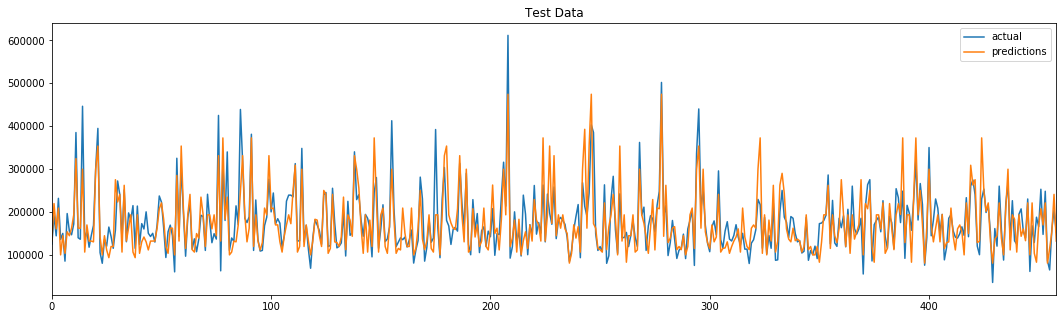

In [76]:
plot_df = pd.DataFrame({"actual": Y_real, "predictions": predictions})
plot_df.plot(figsize=(18, 5), title="Test Data")

In [313]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [314]:
sk_train_df = pd.read_csv('/media/indranil/New Volume1/second sem/SMAI/Assignment 1/q3/dataset/train.csv')
sk_train_df.drop(['Id','Alley','PoolQC','Fence','MiscFeature'], axis =1, inplace = True)
sk_train_df['LotFrontage'].fillna(sk_train_df['LotFrontage'].mean(), inplace = True)
sk_train_df['MasVnrType'].fillna(sk_train_df['MasVnrType'].mode()[0], inplace = True)
sk_train_df['MasVnrArea'].fillna(sk_train_df['MasVnrArea'].mean(), inplace = True)
sk_train_df['BsmtQual'].fillna(sk_train_df['BsmtQual'].mode()[0], inplace = True)
sk_train_df['BsmtCond'].fillna(sk_train_df['BsmtCond'].mode()[0], inplace = True)
sk_train_df['BsmtExposure'].fillna(sk_train_df['BsmtExposure'].mode()[0], inplace = True)
sk_train_df['BsmtFinType1'].fillna(sk_train_df['BsmtFinType1'].mode()[0], inplace = True)
sk_train_df['BsmtFinType2'].fillna(sk_train_df['BsmtFinType2'].mode()[0], inplace = True)
sk_train_df['Electrical'].fillna(sk_train_df['Electrical'].mode()[0], inplace = True)
sk_train_df['FireplaceQu'].fillna(sk_train_df['FireplaceQu'].mode()[0], inplace = True)
sk_train_df['GarageType'].fillna(sk_train_df['GarageType'].mode()[0], inplace = True)
sk_train_df['GarageYrBlt'].fillna(sk_train_df['GarageYrBlt'].mean(), inplace = True)
sk_train_df['GarageFinish'].fillna(sk_train_df['GarageFinish'].mode()[0], inplace = True)
sk_train_df['GarageQual'].fillna(sk_train_df['GarageQual'].mode()[0], inplace = True)
sk_train_df['GarageCond'].fillna(sk_train_df['GarageCond'].mode()[0], inplace = True)
sk_train_labels = sk_train_df.iloc[:,-1:]

In [315]:
sk_test_df = pd.read_csv('/media/indranil/New Volume1/second sem/SMAI/Assignment 1/q3/dataset/test.csv')
sk_test_result_df = pd.read_csv('/media/indranil/New Volume1/second sem/SMAI/Assignment 1/q3/dataset/test_labels.csv', header= None)
sk_test_df.drop(['Id','Alley','PoolQC','Fence','MiscFeature'], axis =1, inplace = True)
sk_test_df['LotFrontage'].fillna(sk_test_df['LotFrontage'].mean(), inplace = True)
sk_test_df['MasVnrType'].fillna(sk_test_df['MasVnrType'].mode()[0], inplace = True)
sk_test_df['MasVnrArea'].fillna(sk_test_df['MasVnrArea'].mean(), inplace = True)
sk_test_df['BsmtQual'].fillna(sk_test_df['BsmtQual'].mode()[0], inplace = True)
sk_test_df['BsmtCond'].fillna(sk_test_df['BsmtCond'].mode()[0], inplace = True)
sk_test_df['BsmtExposure'].fillna(sk_test_df['BsmtExposure'].mode()[0], inplace = True)
sk_test_df['BsmtFinType1'].fillna(sk_test_df['BsmtFinType1'].mode()[0], inplace = True)
sk_test_df['BsmtFinType2'].fillna(sk_test_df['BsmtFinType2'].mode()[0], inplace = True)
sk_test_df['Electrical'].fillna(sk_test_df['Electrical'].mode()[0], inplace = True)
sk_test_df['FireplaceQu'].fillna(sk_test_df['FireplaceQu'].mode()[0], inplace = True)
sk_test_df['GarageType'].fillna(sk_test_df['GarageType'].mode()[0], inplace = True)
sk_test_df['GarageYrBlt'].fillna(sk_test_df['GarageYrBlt'].mean(), inplace = True)
sk_test_df['GarageFinish'].fillna(sk_test_df['GarageFinish'].mode()[0], inplace = True)
sk_test_df['GarageQual'].fillna(sk_test_df['GarageQual'].mode()[0], inplace = True)
sk_test_df['GarageCond'].fillna(sk_test_df['GarageCond'].mode()[0], inplace = True)
sk_test_data = sk_test_df.iloc[:,:]
sk_test_labels = sk_test_result_df.iloc[:,1:]

In [316]:
sk_train_df.drop(['SalePrice'],axis = 1, inplace = True)

In [317]:
sk_test_labels = np.array(sk_test_labels)
sk_test_labels.shape

(460, 1)

In [318]:
categorical_feature_mask = sk_train_df.dtypes==object
categorical_cols = sk_train_df.columns[categorical_feature_mask].tolist()
sk_train_df[categorical_cols] = sk_train_df[categorical_cols].apply(lambda col: le.fit_transform(col))


In [319]:
categorical_feature_mask = sk_test_df.dtypes==object
categorical_cols = sk_test_df.columns[categorical_feature_mask].tolist()
sk_test_df[categorical_cols] = sk_test_df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [306]:
sk_train = np.array(sk_train_df)
test_data = np.array(sk_test_df)

Using sk-learn decision tree MSE - 1469968138.8347826 and MAE - 27720.165217391303 and R2 score - 0.7218500721253207

In [307]:
regressor = DecisionTreeRegressor()
regressor.fit(sk_train, sk_train_labels)
sk_predictions = regressor.predict(test_data)
sk_Y_real = list()
for i in np.array(sk_test_labels):
    sk_Y_real.append(i[0])
mse = mean_square_error(np.array(sk_Y_real),np.array(sk_predictions))
mae = mean_absolute_error(np.array(sk_Y_real),np.array(sk_predictions))
print("MSE ",mse)
print("MAE", mae)
r2_score(np.array(sk_Y_real), np.array(sk_predictions))

MSE  1469968138.8347826
MAE 27720.165217391303


0.7218500721253207

# Graph has been plotted between the predicted value based on the decision tree built using sk-learn and the actual value

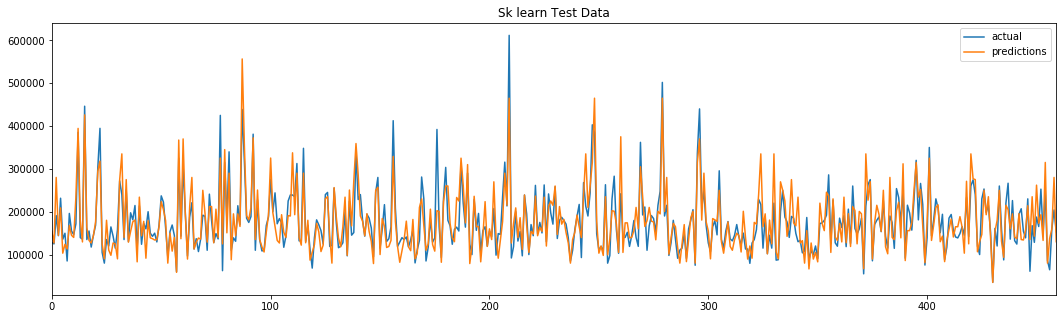

In [309]:
plot_df = pd.DataFrame({"actual": sk_Y_real, "predictions": sk_predictions})
plot_df.plot(figsize=(18, 5), title="Sk learn Test Data")